In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

data\healthycows\imgs001.jpg
data\healthycows\imgs002.jpg
data\healthycows\imgs003.jpg
data\healthycows\imgs004.jpg
data\healthycows\imgs005.jpg
data\healthycows\imgs006.jpg
data\healthycows\imgs007.jpg
data\healthycows\imgs008.jpg
data\healthycows\imgs009.jpg
data\healthycows\imgs010.jpg
data\healthycows\imgs011.jpg
data\healthycows\imgs012.jpg
data\healthycows\imgs013.jpg
data\healthycows\imgs014.jpg
data\healthycows\imgs015.jpg
data\healthycows\imgs016.jpg
data\healthycows\imgs017.jpg
data\healthycows\imgs018.jpg
data\healthycows\imgs019.jpg
data\healthycows\imgs020.jpg
data\healthycows\imgs021.jpg
data\healthycows\imgs022.jpg
data\healthycows\imgs023.jpg
data\healthycows\imgs024.jpg
data\healthycows\imgs025.jpg
data\healthycows\imgs026.jpg
data\healthycows\imgs027.jpg
data\healthycows\imgs028.jpg
data\healthycows\imgs029.jpg
data\healthycows\imgs030.jpg
data\healthycows\imgs031.jpg
data\healthycows\imgs032.jpg
data\healthycows\imgs033.jpg
data\healthycows\imgs034.jpg
data\healthyco

In [28]:
import tensorflow as tf
from keras.applications.resnet import ResNet50
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import seaborn as sns
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, LambdaCallback
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model
from tensorflow import keras

In [3]:
BATCH_SIZE = 5
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 936 files belonging to 2 classes.


In [7]:
class_names=dataset.class_names
class_names

['healthycows', 'lumpycows']

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(5, 256, 256, 3)
[1 0 1 1 1]


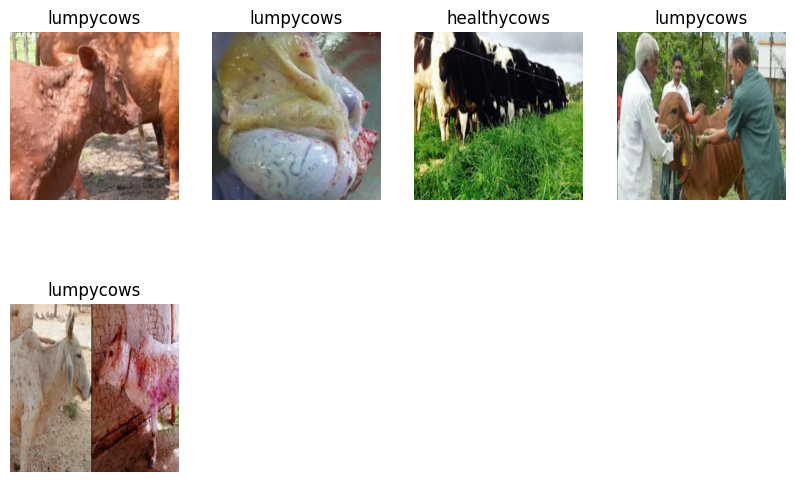

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(5):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [12]:
len(dataset)

188

In [13]:
train=0.8

In [14]:
df_test=dataset.skip(18)
val_df=df_test

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_df,val_df,test_df=get_dataset_partitions_tf(dataset)

In [17]:
train_ds = train_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [19]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.25),
    layers.experimental.preprocessing.RandomZoom((0.5,0.2)),
    layers.experimental.preprocessing.RandomZoom((-0.7,-0.2)),
    layers.experimental.preprocessing.RandomContrast(factor=0.1)
])

In [20]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

n_classes = 2
net = ResNet50(
    weights='imagenet', # Load weights pre-trained on ImageNet.
     include_top=False, # Do not include the ImageNet classifier at the top.
     input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))


In [35]:
model = net.output
model = resize_and_rescale(model)
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(1, activation="softmax")(model)
model = Model(inputs= net.input, outputs= model)

#compile our model.
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

 conv2_block1_1_conv (Conv2D)   (None, 64, 64, 64)   4160        ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_1_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_1_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block1_2_conv (Conv2D)   (None, 64, 64, 64)   36928       ['conv2_block1_1_relu[0][0]']    
                                                                                                  
 conv2_blo

In [36]:
BATCH_SIZE = 64
EPOCHS = 50

Checkpoint = ModelCheckpoint(filepath = 'model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.h5',monitor = 'val_loss', verbose = 1, save_best_only = True,mode = 'min')

ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks = [ES,RL,Checkpoint,LambdaCallback()]

history = model.fit(train_ds,validation_data = val_ds,epochs = EPOCHS,callbacks = callbacks, batch_size=BATCH_SIZE)

Epoch 1/50
  8/150 [>.............................] - ETA: 19:58 - loss: 0.0000e+00 - accuracy: 0.4250

KeyboardInterrupt: 

In [ ]:
model.evaluate(test_ds)

In [ ]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(img)
    img_array=tf.expand_dims(img_array,0)
    predictions = model.predict(img_array)
    print(predictions)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class,confidence

In [ ]:
model.save("CNN.h5")

In [ ]:
from tensorflow import keras
model1 = keras.models.load_model('CNN.h5')
for img,label in test_df.take(1):
    for i in range(5):
        img_array=tf.keras.preprocessing.image.img_to_array(img[i].numpy())
        img_array=tf.expand_dims(img_array,0)
        predictions = model1.predict(img_array)
        print(class_names[np.argmax(predictions[0])],np.max(predictions[0]))

In [ ]:
from tensorflow import keras
model1 = keras.models.load_model('CNN.h5')
for img,label in test_df.take(1):
    for i in range(5):
        img_array=tf.keras.preprocessing.image.img_to_array(img[i].numpy())
        img_array=tf.expand_dims(img_array,0)
        predictions = model1.predict(img_array)
        print(class_names[np.argmax(predictions[0])],np.max(predictions[0]))

In [ ]:
import numpy as np

plt.figure(figsize=(15, 15))
for img,label in test_df.take(1):
    for i in range(5):
        plt.subplot(3,3,i+1)
        plt.imshow(img[i].numpy().astype("uint8"))
        pred,conf=Predict(model,img[i].numpy())
#         print(pred,conf)
        actual_class = class_names[label[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {pred}.\n Confidence: {conf}%")
        plt.axis("off")